<a href="https://colab.research.google.com/github/BenJMaurel/Wine_project/blob/main/wine_project_11_12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Partie 0 : Quelques imports de bon fonctionnement

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil
import random as rd

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris

In [4]:
import csv

def read_glove_vecs(glove_file):
    with open(glove_file, 'r', encoding='utf-8') as f:
        words = set()
        word_to_vec_map = {}
        for line in f:
            line = line.strip().split()
            curr_word = line[0]
            words.add(curr_word)
            word_to_vec_map[curr_word] = np.array(line[1:], dtype=np.float64)
        
        i = 1
        words_to_index = {}
        index_to_words = {}
        for w in sorted(words):
            words_to_index[w] = i
            index_to_words[i] = w
            i = i + 1
    return words_to_index, index_to_words, word_to_vec_map

In [5]:
def convert_to_one_hot(vecteur):
    n_values = int(np.max(vecteur) + 1)
    oh = np.eye(n_values)[vecteur]
    return oh

In [6]:
data = pd.read_csv("/content/drive/My Drive/Wine_project/winemag-data-130k-v2.csv")

In [7]:
word_to_index, index_to_word, word_to_vec_map = read_glove_vecs('/content/drive/My Drive/Wine_project/glove.6B.50d.txt')

# Partie 1: Statistiques descriptives

In [ ]:
data = data.drop('Unnamed: 0', axis = 1)
data.columns


Index(['country', 'description', 'designation', 'points', 'price', 'province',
       'region_1', 'region_2', 'taster_name', 'taster_twitter_handle', 'title',
       'variety', 'winery'],
      dtype='object')

In [ ]:
data['country'].nunique()
data['region_2'].nunique()
data['province'].count()

129908

In [ ]:
data.describe()

,points,price
count,129971.000000,120975.000000
mean,88.447138,35.363389
std,3.039730,41.022218
min,80.000000,4.000000
25%,86.000000,17.000000
50%,88.000000,25.000000
75%,91.000000,42.000000
max,100.000000,3300.000000


In [ ]:
data.isnull().sum()

country                     63
description                  0
designation              37465
points                       0
price                     8996
province                    63
region_1                 21247
region_2                 79460
taster_name              26244
taster_twitter_handle    31213
title                        0
variety                      1
winery                       0
dtype: int64

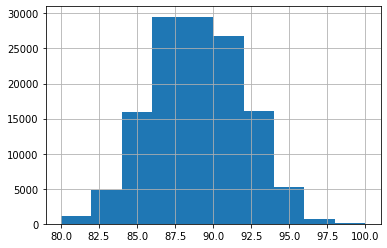

In [ ]:
fig = data['points'].hist()
plt.show()

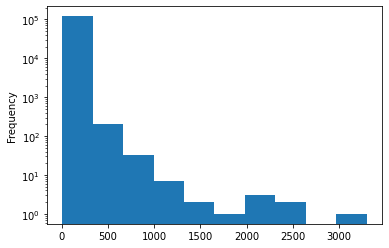

In [ ]:
fig = data['price'].plot(kind = 'hist', logy=True)
plt.show()

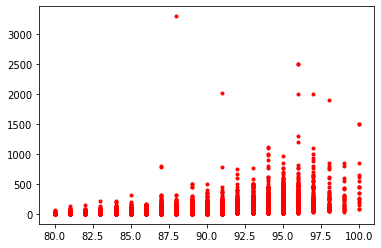

In [ ]:
plt.plot(data['points'], data['price'], 'r.')

In [ ]:
priceForPoint = data.groupby(by="points").mean()

In [ ]:
#PriceForPoint donne la moyenne du prix de la bouteille pour un nbr de point donné

[]

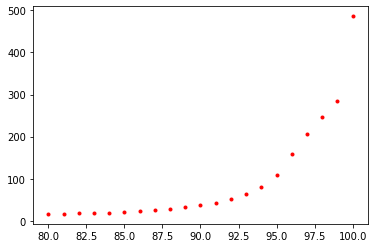

In [ ]:
plt.plot(priceForPoint.index, priceForPoint , 'r.')
plt.plot()

[]

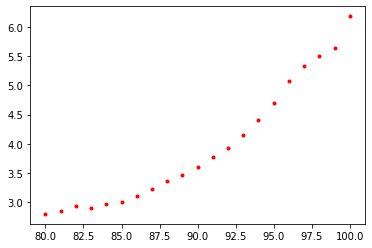

In [ ]:
plt.plot(priceForPoint.index, np.log(priceForPoint) , 'r.')
plt.plot()

In [ ]:
countries = data[ ["country", "winery"] ].groupby(by="country").count().sort_values(by="winery")[::-1]
countries.count()

winery    43
dtype: int64

In [ ]:
countries_price = data[ ["country", "price"]].groupby(by ="country").mean()

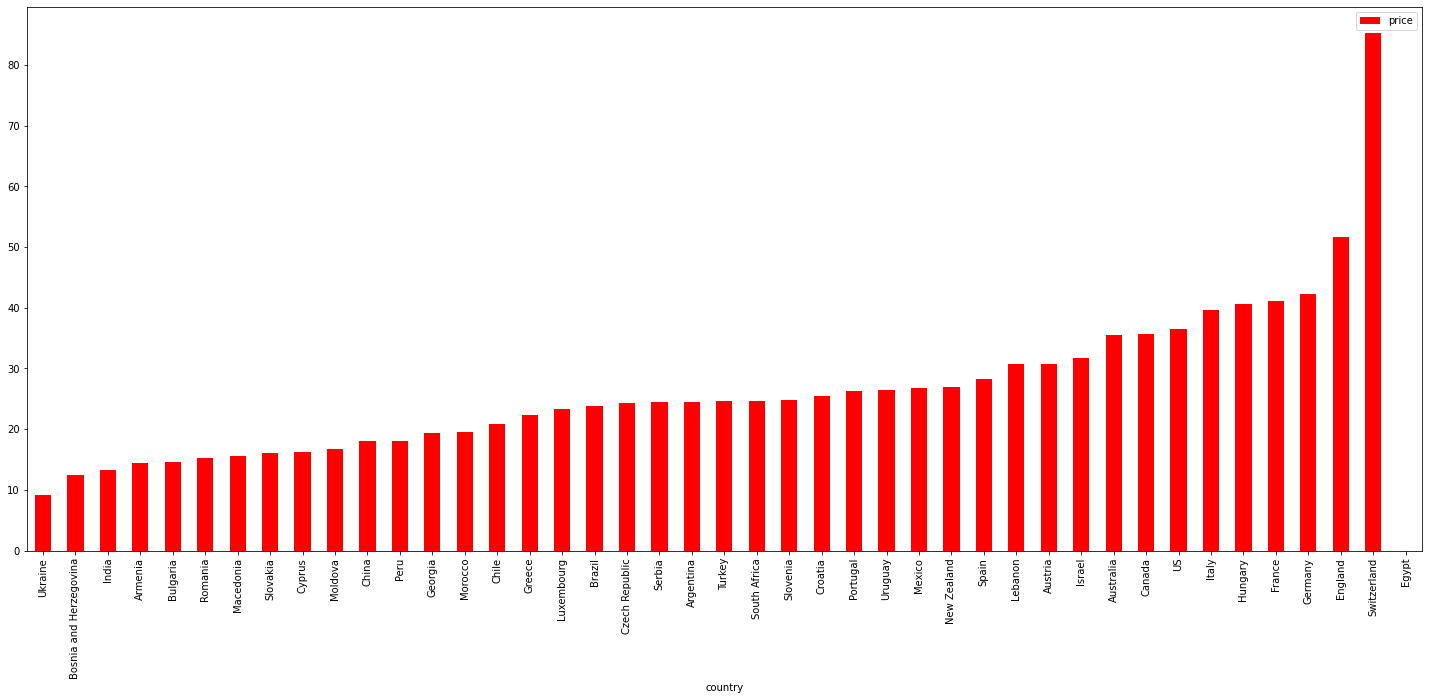

In [ ]:
countries_price.sort_values('price').plot(kind = "bar", figsize = (25,10), color = 'red')

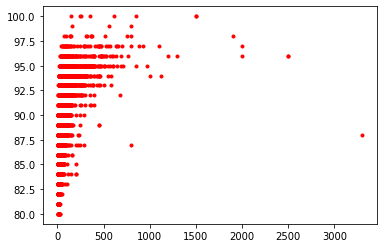

In [ ]:
dfr=data[data["country"] == 'France']
plt.plot(dfr['price'],dfr['points'], 'r.')

In [ ]:
dfr_max=dfr[dfr['price']> dfr['price'].quantile( q = 0.99)]

In [ ]:
dfr_max=dfr_max[['region_1','winery']]

In [ ]:
dfr_max.count()

region_1    172
winery      172
dtype: int64

In [ ]:
dfr_max_winery = dfr_max.groupby('region_1').count().sort_values(by="winery")[::-1]
dfr_max_winery.head()

,winery
region_1,
Champagne,22
Pessac-Léognan,13
Pauillac,12
Chevalier-Montrachet,11
Bâtard-Montrachet,10


# Partie 2 : Premier Modèle

## Modèle 1.1

In [8]:
data_1 = data.sample(frac = 0.1, random_state = 1)
X = data_1['description']
Y = data_1['points']

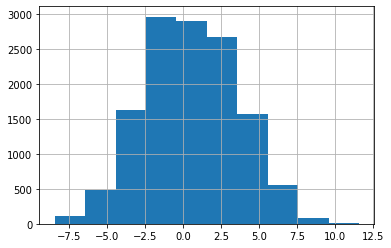

In [9]:
fig = Y.hist()
plt.show()

On va essayer de prédire, en fonction de la description, un score en séparant en 5 parties égales l'ensemble des scores possibles

In [122]:
groupe = (max(Y)-min(Y))/5
print("on va faire 5 catégories de taille", groupe+0.001)

on va faire 5 catégories de taille 4.001


In [13]:
# Creating the 5 classes, transform X, Y into array

Y = np.array(Y)
X = np.array(X)
mini = min(Y_corr)
for idx in range(len(Y_corr)):
    Y_corr[idx] = abs(Y_corr[idx] - mini)//4.001   

In [14]:
X_train,X_test,Y_train,Y_test=train_test_split(X,Y_corr,test_size=0.2)
Y_train = np.array(Y_train, dtype = int)

The model is simple: thanks to the glove document, we will be able to transform a word into a vector.

1.   We do that for every word in the descrption
2.   sum up the vectors and take the average


This give us "an idea" of the sentence (if the sentence is positive or negative)

It will be our new X in the regression

In [15]:
def sentence_to_avg(sentence, word_to_vec_map):
 
    # Step 1: Split sentence into list of lower case words
    words = sentence.lower().split()

    # Initialize the average word vector
    avg = np.zeros(50)
    
    # Step 2: average the word vectors. You can loop over the words in the list "words".
    total = 0
    for w in words:
        while w not in word_to_vec_map.keys():
            if w[1:] in word_to_vec_map.keys():
                w = w[1:]
            else:
                w = w[:-1]
        total += word_to_vec_map[w]
    avg = total/len(words)
    
    
    return avg

In [16]:
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()


def model(X, Y, word_to_vec_map, learning_rate = 0.01, num_iterations = 800):

    m = Y.shape[0]                          # number of training examples
    n_y = 5                                 # number of classes  
    n_h = 50                                # dimensions of the GloVe vectors 
    
    # Initialize parameters using Xavier initialization
    W = np.random.randn(n_y, n_h) / np.sqrt(n_h)
    b = np.zeros((n_y,)) 
    
    # Convert Y to Y_onehot with n_y classes
    Y_oh = convert_to_one_hot(Y) 
    
    # Optimization loop
    for t in range(num_iterations): 
        for i in range(m):          
            
            avg = sentence_to_avg(X[i], word_to_vec_map)
            z = np.dot(W,avg) + b
            a = softmax(z)

            cost = - np.dot(Y_oh[i],np.log(a))
            
            # Compute gradients 
            dz = a - Y_oh[i]
            dW = np.dot(dz.reshape(n_y,1), avg.reshape(1, n_h))
            db = dz

            # Update parameters with Stochastic Gradient Descent
            W = W - learning_rate * dW
            b = b - learning_rate * db
        
        if t % 100 == 0:
            print("Epoch: " + str(t) + " --- cost = " + str(cost))
            pred = predict(X, Y, W, b, word_to_vec_map)

    return pred, W, b

In [17]:
def predict(X, Y, W, b, word_to_vec_map):
    """
    X -- input data containing sentences, numpy array of shape (m, None)
    Y -- labels, numpy array of shape (m, 1)
    
    Returns:
    pred -- numpy array of shape (m, 1) with your predictions
    """
    m = X.shape[0]
    pred = np.zeros((m, 1))
    
    for j in range(m):                      
        
        # Split jth test example (sentence) into list of lower case words
        words = X[j].lower().split()
        
        # initialising avg
        avg = np.zeros((50,))
        for w in words:
          #Some problems occur with ".split()", sometimes we don't want the first or the last character.
          #Kind of the hard way to do it, but it works...
            while w not in word_to_vec_map.keys():
                if w[1:] in word_to_vec_map.keys():
                    w = w[1:]
                else:
                    w = w[:-1]
            avg += word_to_vec_map[w]
        avg = avg/len(words)

        # Forward propagation
        Z = np.dot(W, avg) + b
        A = softmax(Z)
        pred[j] = np.argmax(A)
        
    print("Accuracy: "  + str(np.mean((pred[:] == Y.reshape(Y.shape[0],1)[:]))))
    
    return pred

In [18]:
#Training the model
pred, W, b = model(X_train, Y_train, word_to_vec_map)

Epoch: 0 --- cost = 0.6322023401767074
Accuracy: 0.5024526305665096
Epoch: 100 --- cost = 0.45602008366218544
Accuracy: 0.5465037991728383
Epoch: 200 --- cost = 0.46133847137813977
Accuracy: 0.5473694334904299
Epoch: 300 --- cost = 0.4649444939868927
Accuracy: 0.5471770703087429


In [19]:
print("Training set:")
pred_train = predict(X_train, Y_train, W, b, word_to_vec_map)
print('Test set:')
pred_test = predict(X_test, Y_test, W, b, word_to_vec_map)

Training set:
Accuracy: 0.5480427046263345
Test set:
Accuracy: 0.5434615384615384


On se retrouve avec une accuracy de 55%. Ce qui est déjà bien mieux que le hasard (5 catégories) mais à nuancer par le choix de nos catégories... (cf modèle 1.2)

In [123]:
#A little test to see if it works...
X_my_sentences = np.array(["I love that wine, it is so tasteful. A great success to see in the future"])
Y_my_labels = np.array([[3]])
pred = predict(X_my_sentences, Y_my_labels , W, b, word_to_vec_map)
pred

Accuracy: 1.0


array([[3.]])

Vérifions à partir d'une matrice de confusion si les résultats sont pertinents

In [22]:
def plot_confusion_matrix(y_actu, y_pred, title='Confusion matrix', cmap=plt.cm.gray_r):
    
    df_confusion = pd.crosstab(y_actu, y_pred.reshape(y_pred.shape[0],), rownames=['Actual'], colnames=['Predicted'], margins=True)
    
    df_conf_norm = df_confusion / df_confusion.sum(axis=1)
    
    plt.matshow(df_confusion, cmap=cmap)

    plt.colorbar()
    tick_marks = np.arange(len(df_confusion.columns))
    plt.xticks(tick_marks, df_confusion.columns, rotation=45)
    plt.yticks(tick_marks, df_confusion.index)
    
    plt.ylabel(df_confusion.index.name)
    plt.xlabel(df_confusion.columns.name)

Predicted  0.0   1.0   2.0  3.0   All
Actual                               
0.0         48   153    28    0   229
1.0         25   712   388    5  1130
2.0          2   324   636   16   978
3.0          0    33   207   17   257
4.0          0     1     5    0     6
All         75  1223  1264   38  2600


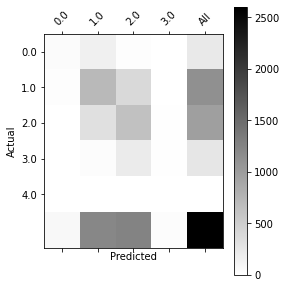

In [23]:
print(pd.crosstab(Y_test, pred_test.reshape(Y_test.shape), rownames=['Actual'], colnames=['Predicted'], margins=True))
plot_confusion_matrix(Y_test, pred_test)

## Modèle 1.2

Puisqu'on a une distribution pour Y qui ressemble à une loi normale et non une loi uniforme, on essai cette fois de séparer les classes en fonction des quantiles (20% pour chaque classe) et on reteste le modèle à partir de ça

In [33]:
quant = Y.quantile([0.2,0.4,0.6,0.8,1])

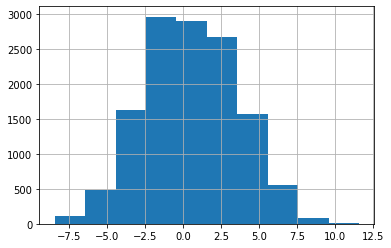

In [34]:
data_12 = data.sample(frac = 1, random_state = 1)
X = data_12['description']
Y = data_12['points']

fig = Y.hist()
plt.show()

In [ ]:
#This is the only difference with model 1.1: approximatively 20% of the values are in each classes
Y = np.array(Y)
for idx in range(len(Y_)):
    if Y[idx] <= quant[0.2] and np.sum(Y ==0) < len(Y)/5:
        Y[idx] = 0
    elif Y[idx] <= quant[0.4] and np.sum(Y ==0) < len(Y)/5:
        Y[idx] = 1
    elif Y[idx] <= quant[0.6] and np.sum(Y ==0) < len(Y)/5:
        Y[idx] = 2
    elif Y[idx] <= quant[0.8] and np.sum(Y ==0) < len(Y)/5:
        Y[idx] = 3
    else:
        Y[idx] = 4

In [35]:
#Split the set in train/test
X = np.array(X)
Y = np.array(Y, dtype=int)
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.2)


In [36]:
#train the model
pred, W_1, b_1 = model(X_train, Y_train, word_to_vec_map)

Epoch: 0 --- cost = 1.1530848188150504
Accuracy: 0.30066365297682024
Epoch: 100 --- cost = 1.3766486053927778
Accuracy: 0.3925170722323747
Epoch: 200 --- cost = 1.3718787333768339
Accuracy: 0.3930941617774358
Epoch: 300 --- cost = 1.3669010395044026
Accuracy: 0.3932865249591228


In [37]:
print("Training set:")
pred_train = predict(X_train, Y_train, W_1, b_1, word_to_vec_map)
print('Test set:')
pred_test = predict(X_test, Y_test, W_1, b_1, word_to_vec_map)


Training set:
Accuracy: 0.39367125132249686
Test set:
Accuracy: 0.37


Predicted  0.0   1.0  2.0  3.0  4.0   All
Actual                                   
0          247   419    1    2   43   712
1          110   461    2    2   93   668
2           44   359    5    1  146   555
3           12   131    1    1   75   220
4           10   183    2    2  248   445
All        423  1553   11    8  605  2600


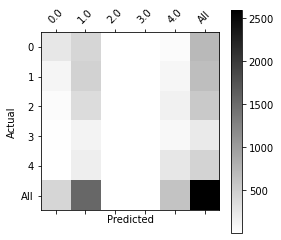

In [38]:
print(pd.crosstab(Y_test, pred_test.reshape(Y_test.shape), rownames=['Actual'], colnames=['Predicted'], margins=True))
plot_confusion_matrix(Y_test, pred_test)

We could expect it, the accuracy value decreases.
To try to have better accuracy we'll use a LSTM model which interpret the whole sentence.

# Partie 3 : Modèle LSTM

Using tensorflow and keras for that model

In [42]:
import numpy as np
from keras.models import Model
from keras.layers import Dense, Input, Dropout, LSTM, Activation
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.initializers import glorot_uniform

The hudge difference here with Model 1 is that we care about the lenght of the description.
So we just put aside any descrption which is "too" long.

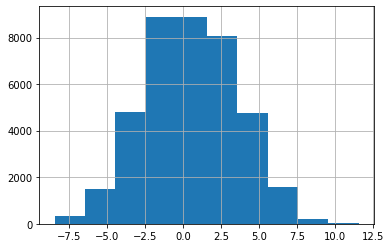

In [43]:
data_3 = data.sample(frac = 0.3, random_state = 1)
data_3= data_3.sort_values(by=['points'])
X_LTSM = data_3['description']
Y = data_3['points']

quant = Y.quantile([0.2,0.4,0.6,0.8,1])
fig = Y.hist()
plt.show()

X_LTSM = np.array(X_LTSM)
Y = np.array(Y)

#Here we check the size of each X
size =[]
for i in range(len(X_LTSM)):
  size.append(len(X_LTSM[i].split()))
size = np.array(size)

#In order to mask the ones that are too long (here the 1% the longest)
mask = np.ones(len(X_LTSM), dtype=bool)
for i in range(len(X_LTSM)):
  if len(X_LTSM[i].split())>np.quantile(size,0.99):
    mask[i] = False
X_LTSM = X_LTSM[mask]
Y = Y[mask] 


for idx in range(len(Y)):
    if Y[idx] <= quant[0.2] and np.sum(Y ==0) < len(Y)/5:
        Y[idx] = 0
    elif Y[idx] <= quant[0.4] and np.sum(Y == 1) < len(Y)/5:
        Y[idx] = 1
    elif Y[idx] <= quant[0.6] and np.sum(Y == 2) < len(Y)/5:
        Y[idx] = 2
    elif Y[idx] <= quant[0.8] and np.sum(Y == 3) < len(Y)/5:
        Y[idx] = 3
    else:
        Y[idx] = 4


In [10]:
size = size[mask]
size.max()
#This will be the size of each sentence. The sentence that are shorter will be
#completed with blank.

71

In [44]:
def sentences_to_indices(X, word_to_index, max_len):
    """
    Converts an array of sentences (strings) into an array of indices corresponding to words in the sentences.
    
    Arguments:
    X -- array of sentences of shape (m, 1)
    word_to_index -- a dictionary containing each word mapped to its index
    max_len -- maximum number of words in a sentence. Here worth size.max() 
    
    Returns:
    X_indices -- array of indices corresponding to words in the sentences from X, of shape (m, max_len)
    """
    
    m = X.shape[0]                                   # number of training examples
    
    X_indices = np.zeros((m, max_len))
    
    for i in range(m):                               # loop over training examples
        
        sentence_words = X[i].lower().split()
        
        j = 0
        
        # Loop over the words of sentence_words
        for w in sentence_words:
          #Same thing than in Modèle 1.1
          while w not in word_to_vec_map.keys():
                if w[1:] in word_to_vec_map.keys():
                    w = w[1:]
                else:
                    w = w[:-1]
          X_indices[i, j] = word_to_index[w]
          j += 1
            
    
    return X_indices

In [45]:
def pretrained_embedding_layer(word_to_vec_map, word_to_index):
    """

    Creates a Keras Embedding() layer and loads in pre-trained GloVe 50-dimensional vectors.
    
    Arguments:
    word_to_vec_map -- dictionary mapping words to their GloVe vector representation.
    word_to_index -- dictionary mapping from words to their indices in the vocabulary

    Returns:
    embedding_layer -- pretrained layer Keras instance
    """
    
    vocab_len = len(word_to_index) + 1                 
    
    emb_dim = word_to_vec_map["cucumber"].shape[0] 
    
    # Initialize the embedding matrix as a numpy array of zeros.
    emb_matrix = np.zeros((vocab_len, emb_dim))
    
    # Step 2
    # Set each row "idx" of the embedding matrix to be 
    # the word vector representation of the idx'th word of the vocabulary
    for word, idx in word_to_index.items():
        emb_matrix[idx, :] = word_to_vec_map[word]

    # Step 3
    # Define Keras embedding layer with the correct input and output sizes
    # Make it non-trainable.
    embedding_layer = Embedding(vocab_len, emb_dim, trainable = True)

    # Build the embedding layer, it is required before setting the weights of the embedding layer. 
    embedding_layer.build((None,)) 
    
    # Set the weights of the embedding layer to the embedding matrix. Your layer is now pretrained.
    embedding_layer.set_weights([emb_matrix])
    
    return embedding_layer

In [17]:
def Wine_model(input_shape, word_to_vec_map, word_to_index):
    """
    LSTM Model and its differents layers
    
    Arguments:
    input_shape -- shape of the input, usually (max_len,)
    word_to_vec_map
    word_to_index 

    Returns:
    model -- a model instance in Keras
    """
    
    # Define Input layer
    sentence_indices = Input(input_shape, dtype= 'int32')
    
    # Create the embedding layer pretrained with GloVe Vectors
    embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index)
    
    # Propagate sentence_indices through your embedding layer
    embeddings = embedding_layer(sentence_indices)
    
    # Propagate the embeddings through an LSTM layer with 128-dimensional hidden state
    X = LSTM(128, return_sequences=True)(embeddings)
    X = Dropout(0.5)(X)

    X = LSTM(128, return_sequences=False)(X)
    X = Dropout(0.5)(X)

    X = Dense( units = 5)(X)
    X = Activation('softmax')(X)
    
    # Create Model instance which converts sentence_indices into X
    model = Model(inputs=sentence_indices, outputs=X)
    
    return model

In [95]:
model = Wine_model((size.max(),), word_to_vec_map, word_to_index)
model.summary()

Model: "functional_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 71)]              0         
_________________________________________________________________
embedding_11 (Embedding)     (None, 71, 50)            20000000  
_________________________________________________________________
lstm_16 (LSTM)               (None, 71, 128)           91648     
_________________________________________________________________
dropout_18 (Dropout)         (None, 71, 128)           0         
_________________________________________________________________
lstm_17 (LSTM)               (None, 128)               131584    
_________________________________________________________________
dropout_19 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 5)               

In [96]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [97]:
#Split into train/test sets
Y_corr = np.array(Y_corr, dtype=int)
X_train,X_test,Y_train,Y_test = train_test_split(X_LTSM,Y_corr,test_size=0.2)

In [98]:
#Convert X and Y to fit the model size:
X_train_indices = sentences_to_indices(X_train, word_to_index, size.max())
Y_train_oh = convert_to_one_hot(Y_train)

In [102]:
model.fit(X_train_indices, Y_train_oh, epochs = 10, batch_size = 1500, shuffle=True)

Epoch 1/10
21/21 [==============================] - 5s 248ms/step - loss: 1.0557 - accuracy: 0.5338
Epoch 2/10
21/21 [==============================] - 5s 249ms/step - loss: 1.0231 - accuracy: 0.5492
Epoch 3/10
21/21 [==============================] - 5s 250ms/step - loss: 1.0008 - accuracy: 0.5577
Epoch 4/10
21/21 [==============================] - 5s 250ms/step - loss: 0.9775 - accuracy: 0.5746
Epoch 5/10
21/21 [==============================] - 5s 241ms/step - loss: 0.9564 - accuracy: 0.5875
Epoch 6/10
21/21 [==============================] - 5s 247ms/step - loss: 0.9381 - accuracy: 0.5977
Epoch 7/10
21/21 [==============================] - 5s 249ms/step - loss: 0.9489 - accuracy: 0.5909
Epoch 8/10
21/21 [==============================] - 5s 243ms/step - loss: 0.9246 - accuracy: 0.6055
Epoch 9/10
21/21 [==============================] - 5s 241ms/step - loss: 0.9007 - accuracy: 0.6195
Epoch 10/10
21/21 [==============================] - 5s 244ms/step - loss: 0.8616 - accuracy: 0.6446

In [103]:
#Test:
X_test_indices = sentences_to_indices(X_test, word_to_index, max_len = size.max())
Y_test_oh = convert_to_one_hot(Y_test)
loss, acc = model.evaluate(X_test_indices, Y_test_oh)
pred = model.predict(X_test_indices)
pred = np.argmax(pred, axis = 1) 
print()
print("Test accuracy = ", acc)

242/242 [==============================] - 1s 6ms/step - loss: 1.3070 - accuracy: 0.4775

Test accuracy =  0.47749030590057373


Predicted     0     1     2     3     4   All
Actual                                       
0          1120   339    89     8     2  1558
1           544   659   251    79     8  1541
2           171   524   532   252    60  1539
3            32   220   495   538   313  1598
4             4    67   183   398   842  1494
All        1871  1809  1550  1275  1225  7730


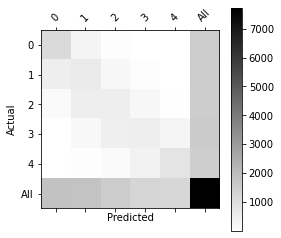

In [104]:
print(pd.crosstab(Y_test, pred.reshape(Y_test.shape), rownames=['Actual'], colnames=['Predicted'], margins=True))
plot_confusion_matrix(Y_test, pred)

That kind of confusion matrix is far better! 
We have now something which seems pretty decent.

But can we go further? Is it possible to evaluate directly the value of the score?

 # Partie 4: Le retour du modèle 1

Let's try it.

In that part we will try to evaluate the value of the score directly and try to put the price in the X to gain more precision.

In [ ]:
#A new sentence_to_avg must be defined because we have to had prices in the X values.

def sentence_to_avg(sentence, word_to_vec_map):
 
    words = sentence.lower().split()

    # Initialize the average word vector
    avg = np.zeros(50)
    
    # Step 2: average the word vectors. 
    total = 0
    for w in words:
        while w not in word_to_vec_map.keys():
            if w[1:] in word_to_vec_map.keys():
                w = w[1:]
            else:
                w = w[:-1]
        total += word_to_vec_map[w]
    avg = total/len(words)
    
    
    return avg

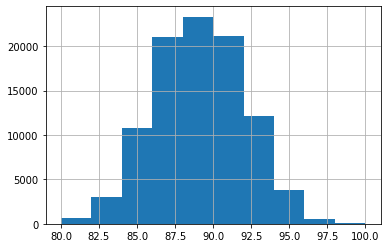

In [ ]:
data_4 = data[['description', 'points', 'price', 'taster_name']].sample(frac = 1, random_state = 1)
data_4 = data_4.dropna()
X = data_4['description']
Y = data_4['points']
prices = data_1000['price']

fig = Y.hist()
plt.show()

Y = np.array(Y)
m=len(X)

#Some preprocessing on X...

X = np.array(X)
X_emb = np.zeros((m,50)) 
prices = np.array(prices)
prices = np.log(prices)
prices = prices - prices.mean()
for i in range(m): 
  X_emb[i] = sentence_to_avg(X[i], word_to_vec_map)
X_emb = np.column_stack((X_emb,prices))

Y = np.array(Y, dtype=int)
X_train,X_test,Y_train,Y_test=train_test_split(X_emb,Y,test_size=0.2)

In [ ]:
def relu(x):
      if x <0:
      x = 0
    return x

In [ ]:
def model_4(X, Y, word_to_vec_map, learning_rate = 0.01, num_iterations = 400):

    m = Y.shape[0]                          # number of training examples
    n_y = 1                                 # number of classes  
    n_h = 51                               # dimensions of the GloVe vectors + 1 (for price)
    
    # Initialize parameters using Xavier initialization
    W = np.random.randn(n_y, n_h) / np.sqrt(n_h)
    b = np.zeros((n_y,)) 
    
    
    # Optimization loop
    for t in range(num_iterations): # Loop over the number of iterations
        for i in range(m):          # Loop over the training examples
          
            # Forward propagate the avg through the softmax layer
            z = np.dot(W,X[i]) + b
            a = relu(z)
            
            # Compute gradients 
            dz = a - Y[i]
            dW = np.dot(dz.reshape(n_y,1), X[i].reshape(1, n_h))
            db = dz

            # Update parameters with Stochastic Gradient Descent
            W = W - learning_rate * dW
            b = b - learning_rate * db
        
        if t % 100 == 0:
            print("Epoch: " + str(t))
            pred = predict_4(X, Y, W, b, word_to_vec_map)

    return pred, W, b

In [ ]:
def predict_4(X, Y, W, b, word_to_vec_map):
    """
    Arguments:
    X -- input data containing avg and prices, numpy array of shape (m, 51)
    Y -- labels, numpy array of shape (m, 1)
    
    Returns:
    pred -- numpy array of shape (m, 1) with your predictions
    """
    m = X.shape[0]
    pred = np.zeros(m)
    
    for j in range(m):                       # Loop over training examples
        
        # Forward propagation
        Z = np.dot(W, X[j]) + b
        A = relu(Z)
        pred[j] = A[0]
        
    print("Loss: "  + str(np.square(np.subtract(Y,pred)).mean() ))
    
    return pred

In [ ]:
pred, W_4, b_4 = model_4(X_train, Y_train, word_to_vec_map)
print(pred)

Epoch: 0
Accuracy: 5.157476464924126
Epoch: 100
Accuracy: 4.450830774806901
Epoch: 200
Accuracy: 4.450982237596474
Epoch: 300
Accuracy: 4.450990823271798
Epoch: 400
Accuracy: 4.450991497683144
Epoch: 500
Accuracy: 4.45099160269804
Epoch: 600
Accuracy: 4.45099161985956
Epoch: 700
Accuracy: 4.450991622379849
[85.69309962 91.93536189 90.20496968 ... 86.05388037 89.96704993
 87.84834505]


In [ ]:
print("Training set:")
pred_train = predict_4(X_train, Y_train, W_4, b_4, word_to_vec_map)
print('Test set:')
pred_test = predict_4(X_test, Y_test, W_4, b_4, word_to_vec_map)

Training set:
Accuracy: 4.450991622717817
Test set:
Accuracy: 4.4537626016700775


In [ ]:
#Let's try to analyse our prediction:
ecart = []
for i in range(0,len(Y_test)):
 ecart.append(abs(pred_test[i] - Y_test[i]))
ecart = np.array(ecart)
print("ecart max:" +str(np.max(ecart)))
print("ecart moy:"+ str(ecart.mean()))
print("variance de l'écart:" + str(ecart.var()))
print(np.quantile(ecart, 0.9))

10.372858700730234 1.661618870254965 1.6927853316826909
[0.26074194 3.42299071]


Predicted   0.0   1.0   2.0   3.0   4.0    All
Actual                                        
0          2481  1251   620   275    74   4701
1          1087  1492  1323   821   306   5029
2           194   496   592   509   245   2036
3            94   557  1025  1407  1152   4235
4             4    63   299   847  2082   3295
All        3860  3859  3859  3859  3859  19296


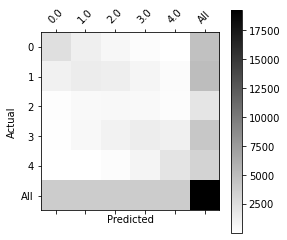

In [ ]:
#Si on veut comparer aux modèles précédents:

Y_test = pd.Series(Y_test)
quant = Y_test.quantile([0.2,0.4,0.6,0.8,1])
Y_res = np.array(Y_test)

for idx in range(len(Y_test)):
    if Y_res[idx] <= quant[0.2]:
        Y_res[idx] = 0
    elif Y_res[idx] <= quant[0.4]:
        Y_res[idx] = 1
    elif Y_res[idx] <= quant[0.6]:
        Y_res[idx] = 2
    elif Y_res[idx] <= quant[0.8]:
        Y_res[idx] = 3
    else:
        Y_res[idx] = 4

pred_test= pd.Series(pred_test)
quant_pred = pred_test.quantile([0.2,0.4,0.6,0.8,1])
pred_res = np.array(pred_test)

for idx in range(len(Y_test)):
    if pred_res[idx] <= quant_pred[0.2]:
        pred_res[idx] = 0
    elif pred_res[idx] <= quant_pred[0.4]:
        pred_res[idx] = 1
    elif pred_res[idx] <= quant_pred[0.6]:
        pred_res[idx] = 2
    elif pred_res[idx] <= quant_pred[0.8]:
        pred_res[idx] = 3
    else:
        pred_res[idx] = 4

print(pd.crosstab(Y_res, pred_res.reshape(Y_test.shape), rownames=['Actual'], colnames=['Predicted'], margins=True))
plot_confusion_matrix(Y_res, pred_res)


In [ ]:
str('Accuracy: ' + str(np.mean(pred_res[:] == Y_res[:]) ) )

'Accuracy: 0.4173922056384743'

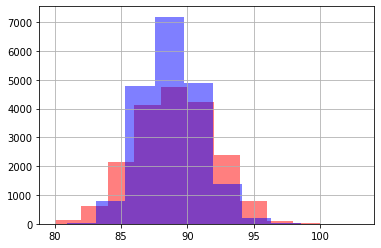

In [ ]:
#Here the distribution can also give us some hints of the quality of the prediction
fig1 = Y_test.hist(alpha = 0.5, color = 'r')
fig2 = pred_test.hist(alpha = 0.5, color = 'b')

plt.show()

# Partie 5 : Retour sur LSTM

 On va donc cette fois chercher à avoir en output directement le score à l'aide du modèle LSTM.
La seule chose qui change réellement, c'est la tête de la fonction de perte...

In [155]:
import numpy as np
from keras.models import Model
from keras.layers import Dense, Input, Dropout, LSTM, Activation
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.initializers import glorot_uniform

In [185]:
data_5 = data.sample(frac = 1, random_state = 1)
X_LTSM = data_5['description']
Y_LTSM = data_5['points']

print(len(X_LTSM))

X_LTSM = np.array(X_LTSM)
Y_LTSM = np.array(Y_LTSM)

size =[]
for i in range(len(X_LTSM)):
  size.append(len(X_LTSM[i].split()))
size = np.array(size)

mask = np.ones(len(X_LTSM), dtype=bool)
for i in range(len(X_LTSM)):
  if len(X_LTSM[i].split())>np.quantile(size,0.99):
    mask[i] = False
X_LTSM = X_LTSM[mask]
Y_LTSM = Y_LTSM[mask] 
size = size[mask] 

#Preprocessing of the Y values:
min_Y = Y_LTSM.min()
max_Y = Y_LTSM.max()
Y_LTSM = (Y_LTSM - min_Y)/(max_Y - min_Y)



129971


In [186]:
#Split train/test

X_train,X_test,Y_train,Y_test=train_test_split(X_LTSM,Y_LTSM,test_size=0.2)
X_train_indices = sentences_to_indices(X_train, word_to_index, size.max())

In [187]:
def Wine_model_2(input_shape, word_to_vec_map, word_to_index):
    """
    Arguments:
    input_shape -- shape of the input, here size.max()
    word_to_vec_map
    word_to_index 

    Returns:
    model -- model instance in Keras
    """
    
    sentence_indices = Input(input_shape, dtype= 'int32')
    
    # Create the embedding layer pretrained with GloVe Vectors
    embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index)
    
    # Propagate sentence_indices through your embedding layer
    embeddings = embedding_layer(sentence_indices)
    
    X = LSTM(128, return_sequences= True)(embeddings)
    X = Dropout(0.5)(X)
    
    X = LSTM(128, return_sequences= False)(X)
    X = Dropout(0.5)(X)
    
    #We just had a new 128 Dense Layer (because it works better...)
    X = Dense ( units = 128 )(X)
    X = Activation('relu')(X)
    X = Dropout(0.5)(X)

    X = Dense( units = 1 )(X)
    X = Activation('linear')(X)
    
    model = Model(inputs=sentence_indices, outputs=X)
    
    return model

In [188]:
model_2 = Wine_model_2((size.max(),), word_to_vec_map, word_to_index)
model_2.summary()

Model: "functional_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 71)]              0         
_________________________________________________________________
embedding_5 (Embedding)      (None, 71, 50)            20000000  
_________________________________________________________________
lstm_10 (LSTM)               (None, 71, 128)           91648     
_________________________________________________________________
dropout_15 (Dropout)         (None, 71, 128)           0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 128)               131584    
_________________________________________________________________
dropout_16 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 128)             

In [46]:
# Compute that to load a model : 

from keras.models import model_from_json
from keras.models import load_model


json_file = open('/content/drive/My Drive/Wine_project/final_p5.json', 'r')
model_json = json_file.read()
json_file.close()
model = model_from_json(model_json)
# load weights into new model
model_2.load_weights("/content/drive/My Drive/Wine_project/final_p5.h5")
print("Loaded model from disk")
model_2.save('/content/drive/My Drive/Wine_project/final_p5.hdf5')
model_2=load_model('/content/drive/My Drive/Wine_project/final_p5.hdf5')
model_2.compile(optimizer = 'adam', loss= 'mean_squared_error', metrics= [metrics.mean_squared_error, metrics.mean_absolute_error]) 


X_test_indices = sentences_to_indices(X_test, word_to_index, size.max())
loss = model.evaluate(X_test_indices, Y_test)

ValueError: ignored

In [189]:
from keras import metrics
model_2.compile(loss='mean_squared_error', optimizer='adam', metrics= [metrics.mean_squared_error, 
                       metrics.mean_absolute_error])

In [199]:
model_2.fit(X_train_indices, Y_train, epochs = 3, batch_size = 1500, shuffle=True)

Epoch 1/3
69/69 [==============================] - 18s 255ms/step - loss: 0.0069 - mean_squared_error: 0.0069 - mean_absolute_error: 0.0653
Epoch 2/3
 3/69 [>.............................] - ETA: 11s - loss: 0.0072 - mean_squared_error: 0.0072 - mean_absolute_error: 0.0666

KeyboardInterrupt: ignored

In [195]:
X_test_indices = sentences_to_indices(X_test, word_to_index, size.max())
loss, mse, mae = model_2.evaluate(X_test_indices, Y_test)
pred = model_2.predict(X_test_indices)

805/805 [==============================] - 4s 5ms/step - loss: 0.0067 - mean_squared_error: 0.0067 - mean_absolute_error: 0.0642


In [200]:
from keras.models import model_from_json
from keras.models import load_model
model_json = model_2.to_json()
with open("/content/drive/My Drive/Wine_project/final_p5.json", "w") as json_file:
  json_file.write(model_json)
model_2.save_weights("/content/drive/My Drive/Wine_project/final_p5.hdf5")

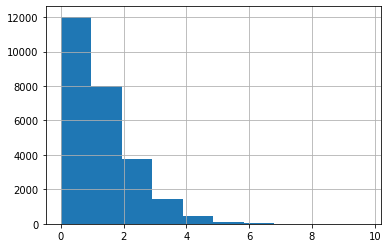

In [197]:
pred_post,Y_test_post = pred*(max_Y - min_Y) + min_Y,Y_test*(max_Y - min_Y) + min_Y
pred_post = np.reshape(pred_post,(len(pred)))
ecart = abs(pred_post - Y_test_post)
pd.Series(ecart).hist()
plt.show()

In [201]:
np.quantile(ecart, 0.90)

2.6887382507324222

In [203]:
#petit test aléatoire:
i = rd.randint(0,len(pred_post))
print("Prédiction:" + str(pred_post[i]))
print("Réel :" +str(Y_test_post[i]))

Prédiction:87.972336
Réel :86.0


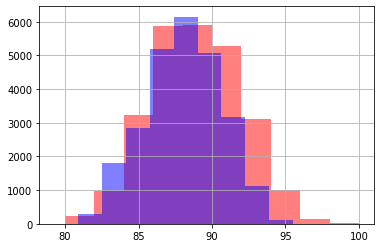

In [204]:
fig1 = pd.Series(Y_test_post).hist(alpha = 0.5, color = 'r')
fig2 = pd.Series(pred_post).hist(alpha = 0.5, color = 'b')

plt.show()

In [155]:
def predict_wine_score(sentence):
  #sentence MUST BE a string, it is the sentence describing the wine 
  #return the score (out of 100) predicted for the bottle described
  sentence = np.array([sentence])
  sentence = sentences_to_indices(sentence,word_to_index, size.max())
  return model_2.predict(sentence)[0][0]*(max_Y - min_Y) + min_Y

In [166]:
#Petit exemple avec ce vin 
#https://www.vivino.com/FR/fr/sainte-marguerite-symphonie-cotes-de-provence-rouge/w/3496774?year=2018&price_id=22596529&cart_item_source=nav-explore
#noté 4.3/5 ce qui équivaut à 86/100

predict_wine_score("After the white, the red. Wine with a nice roundness, a nice spicy and fleshy side. It is powerful and subtle at the same time. It's organic and it's all good. One of my reference domains in Côtes de Provence.")

86.099613904953

## Prediction du prix

Puisque le modèle semble bien marcher, on tente notre chance en essayant de prédire le prix.

129971


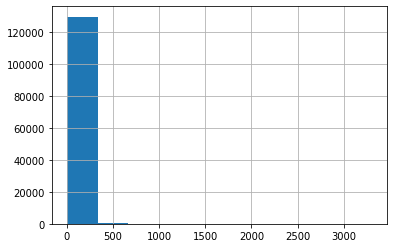

89

In [237]:

data_10000 = data.sample(frac = 1, random_state = 1)
X_LTSM = data_10000['description']
Y_LTSM = data_10000['price']
Y_LTSM = Y_LTSM.fillna(method='backfill')

print(len(X_LTSM))

X_LTSM = np.array(X_LTSM)
Y_LTSM = np.array(Y_LTSM)

mask1 = np.ones(len(Y_LTSM), dtype=bool)
for i in range(len(X_LTSM)):
  if Y_LTSM[i] >np.quantile(Y_LTSM,0.98):
    mask1[i] = False
X_LTSM = X_LTSM[mask1]
Y_LTSM = Y_LTSM[mask1]

size =[]
for i in range(len(X_LTSM)):
  size.append(len(X_LTSM[i].split()))
size = np.array(size)

mask2 = np.ones(len(X_LTSM), dtype=bool)
for i in range(len(X_LTSM)):
  if len(X_LTSM[i].split())>np.quantile(size,0.999):
    mask2[i] = False
X_LTSM = X_LTSM[mask2]
Y_LTSM = Y_LTSM[mask2] 

pd.Series(Y_LTSM).hist()
plt.show()

min_Y = Y_LTSM.min()
max_Y = Y_LTSM.max()
Y_LTSM = (Y_LTSM - min_Y)/(max_Y - min_Y)
size = size[mask2]
size.max()


In [238]:
#Split train/test

X_train,X_test,Y_train,Y_test=train_test_split(X_LTSM,Y_LTSM,test_size=0.2)
X_train_indices = sentences_to_indices(X_train, word_to_index, size.max())

In [ ]:
# Compute that to load a model : 

from keras.models import model_from_json
from keras.models import load_model


json_file = open('/content/drive/My Drive/Wine_project/final_p5price.json', 'r')
model_json = json_file.read()
json_file.close()
model = model_from_json(model_json)
# load weights into new model
model_2.load_weights("/content/drive/My Drive/Wine_project/final_p5price.h5")
print("Loaded model from disk")
model_2.save('/content/drive/My Drive/Wine_project/final_p5price.hdf5')
model_2=load_model('/content/drive/My Drive/Wine_project/final_p5price.hdf5')
model_2.compile(optimizer = 'adam', loss= 'mean_squared_error', metrics= [metrics.mean_squared_error, metrics.mean_absolute_error]) 


X_test_indices = sentences_to_indices(X_test, word_to_index, size.max())
loss = model.evaluate(X_test_indices, Y_test)

from keras import metrics
model_2.compile(loss='mean_squared_error', optimizer='adam', metrics= [metrics.mean_squared_error, 
                       metrics.mean_absolute_error])


In [239]:
model_2 = Wine_model_2((size.max(),), word_to_vec_map, word_to_index)
model_2.compile(loss='mean_squared_error', optimizer='adam', metrics= [metrics.mean_squared_error, 
                       metrics.mean_absolute_error])
model_2.fit(X_train_indices, Y_train, epochs = 15, batch_size = 1500, shuffle=True)

Epoch 1/15
70/70 [==============================] - 18s 254ms/step - loss: nan - mean_squared_error: nan - mean_absolute_error: nan
Epoch 2/15
54/70 [======================>.......] - ETA: 4s - loss: nan - mean_squared_error: nan - mean_absolute_error: nan

KeyboardInterrupt: ignored

if an error pop up, make sure that you haave run all the required function to define model_2

In [ ]:
from keras.models import model_from_json
from keras.models import load_model
model_json = model_2.to_json()
with open("/content/drive/My Drive/Wine_project/final_p5price.json", "w") as json_file:
  json_file.write(model_json)
model_2.save_weights("/content/drive/My Drive/Wine_project/final_p5price.hdf5")

In [235]:
X_test_indices = sentences_to_indices(X_test, word_to_index, size.max())
loss, mse, mae = model_2.evaluate(X_test_indices, Y_test)
pred = model_2.predict(X_test_indices)

398/398 [==============================] - 2s 5ms/step - loss: 2.1343e-05 - mean_squared_error: 2.1343e-05 - mean_absolute_error: 0.0037


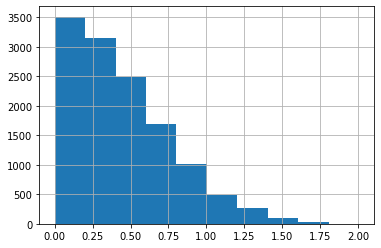

0.3814823145548303

In [228]:
pred_post,Y_test_post = pred*(max_Y - min_Y) + min_Y, Y_test*(max_Y - min_Y) + min_Y
pred_post = np.reshape(pred_post,(len(pred)))
ecart = abs(pred_post - Y_test_post)
pd.Series(ecart).hist()
plt.show()
np.quantile(ecart, 0.5)

In [230]:
#petit test aléatoire:
i = rd.randint(0,len(pred_post))
print("Prédiction:" + str(pred_post[i]))
print("Réel :" +str(Y_test_post[i]))

Prédiction:118.99567
Réel :119.22149990986686


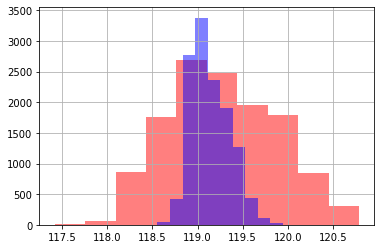

In [236]:
fig1 = pd.Series(Y_test_post).hist(alpha = 0.5, color = 'r')
fig2 = pd.Series(pred_post).hist(alpha = 0.5, color = 'b')

plt.show()

# Conclusion


Le modèle donne déjà des résultats très convaincants!
Cependant il existe encore de nombreuses pistes d'améliorations...
On pourrait se servir du prix pour mieux déterminer le score ou du score pour mieux déterminer le prix.
Il est également possible de prendre en compte l'auteur de la critique pour améliorer la prédiction.

Un autre problème du modèle et la difficulté qu'il a à prédire les prix extremes. Si nous nous intéressons à des bouteilles de très hautes qualité il devient rapidement inutile.

Globalement, ce modèle s'adresse à des acheteurs lambda qui doivent se forger rapidement une opinion d'une bouteille à partir d'une descrpition succinte.